In [1]:
import os
import re
import ctypes
import uproot
import numpy as np
import matplotlib.pyplot as plt

import ROOT

Welcome to JupyROOT 6.28/07


In [2]:
ROOT.gSystem.Load("/pbs/home/g/gdiazlop/Software/HK_Software/fiTQun/install-Linux_x86_64-gcc_9-python_3.10.13/lib/libfiTQunLib.so")

def evaluate_logpdf(q, mus, npars):
    # casting
    npars = int(npars)

    # values to be filled below
    par      = np.zeros(npars)
    muthr    = np.zeros(2)
    coeff    = np.zeros(6)

    # get parameters
    ROOT.fQChrgPDF.Get().SetCPDFParams( q, 0, ctypes.c_int(npars), par, muthr, coeff)

    # evaluate
    logpdf = []
    for mu in mus: logpdf.append(ROOT.fQChrgPDF.flogchrgPDF(mu, npars, par, muthr, coeff))
    logpdf = np.array(logpdf)

    return logpdf

In [3]:
fname  = os.path.expandvars("$HOME/Software/HK_Software/WCSimFQTuningTools/Charge/fitted_cpdf.root")
f  = uproot.open(fname)
f.classnames();

In [4]:
# get qranges and nparameters
nparams, qranges = f["hCPDFrange"].to_numpy()
nqranges = len(nparams)

# get qbins
_, _, qbins = f["charge2D"].to_numpy()
qs = (qbins[1:] + qbins [:-1])/2.

In [9]:
# select random range and bin
rang = np.random.randint(nqranges)
qbin = np.random.randint(1, len(qbins))

print("Selected random Range =", rang, "and qbin =", qbin, "corresponding to q = ", qs[qbin])
print("---------------------------------------")

mus, logpdf = f[f"glogPDF_Rang{rang}_{qbin+1}"].values()
ROOT.fQChrgPDF.Get().LoadParams(fname, 0)

Selected random Range = 0 and qbin = 69 corresponding to q =  26.5
---------------------------------------
fQChrgPDF: Loading parameters from /pbs/home/g/gdiazlop/Software/HK_Software/WCSimFQTuningTools/Charge/fitted_cpdf.root PMT type 0
P_unhit coeff. for Type 0 PMT: c_n=[0.094769, 0.004514, -0.000035, ]


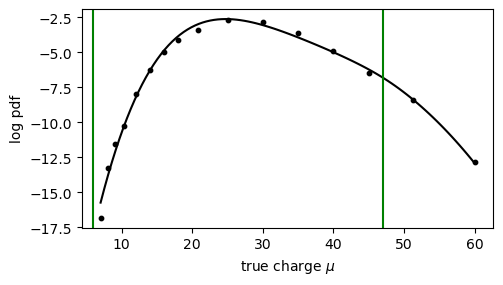

In [10]:
plt.figure(figsize=[5, 3])

plt.scatter(mus, logpdf, s=10, color="k")

# fit
x = np.linspace(mus[0], mus[-1], 100)
y = evaluate_logpdf(qs[qbin], x, nparams[rang])
plt.plot(x, y, color="k")

# thresholds
for i in range(2):
    _,  muthr  =  f[f"gmuthr_Rang{rang}_{i}"].values()
    plt.axvline(muthr[qbin], color="g")

plt.xlabel(r"true charge $\mu$")
plt.ylabel("log pdf")
plt.tight_layout()